In [1]:
# %reset
# Para visualización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
from IPython.display import Audio, Markdown, Image
import pylab
import seaborn as sns

# Números y Datos
import numpy as np
import pandas as pd

# Archivos
import urllib.request
import glob

# Análisis de sonido
import spotipy 

# Machine learning
# importar los paquetes para clustering
from sklearn.preprocessing import StandardScaler

# To work with categorical types
from pandas.api.types import CategoricalDtype

# Clustering (scipy)
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster

# Clustering (sklearn)
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics.pairwise import euclidean_distances

from funciones import plot_silhouette
from funciones import plot_silhouettes_and_sses
from funciones import get_silhouette_avg
from funciones import get_sse
from funciones import vanDongen
from funciones import hopkins

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, Isomap, SpectralEmbedding, TSNE

from sklearn.cluster import AgglomerativeClustering

In [2]:
scaler = MinMaxScaler(feature_range=(0,1))
#scaler = StandardScaler()

Se cargan los dataset

In [3]:
metadata = pd.read_csv('../data/metadata.csv', index_col='id')
audio_features = pd.read_csv('../data/audio_features.csv', index_col='id')
audio_analysis = pd.read_csv('../data/audio_analysis.csv', index_col='id')

audio_features = audio_features[['acousticness','danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness','loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']]

# Para que las comparaciones sean del mismo largo,
# se remueve de audio_feature y metadata el track que no se encuentra en audio_analysis
merged = audio_features.merge(audio_analysis, how = 'left', on = 'id')
id_to_remove = merged[merged.timbre_mean_0.isnull()].index[0]

audio_features = audio_features.drop(id_to_remove, axis = 0)

audio_tracks = pd.merge(audio_features, audio_analysis, how = 'inner', on = 'id')
metadata = metadata.drop(id_to_remove, axis = 0)

# Se ordenan los datasets para que los tracks estén en el mismo orden
audio_features = audio_features.sort_index()
audio_analysis = audio_analysis.sort_index()
audio_tracks = audio_tracks.sort_index()
metadata = metadata.sort_index()

# Comentar si no se quiere estandarizar
audio_features_norm = scaler.fit_transform(audio_features)
audio_analysis_norm = scaler.fit_transform(audio_analysis)
audio_tracks_norm = scaler.fit_transform(audio_tracks)

In [22]:
features = pd.DataFrame(audio_features_norm)
analysis = pd.DataFrame(audio_analysis_norm)
tracks = pd.DataFrame(audio_tracks_norm)

features.to_csv('embedding_projector/audio_features.csv', index=False, sep='\t', header=False)
analysis.to_csv('embedding_projector/audio_analysis.csv', index=False, sep='\t', header=False)
tracks.to_csv('embedding_projector/audio_tracks.csv', index=False, sep='\t', header=False)

In [5]:
metadata.shape

(2205, 17)

In [6]:
audio_features.shape

(2205, 13)

In [7]:
audio_analysis.shape

(2205, 48)

In [8]:
audio_tracks.shape

(2205, 61)

# Tendencia al clustering (Hopkins)

In [9]:
hopkins(audio_features_norm)

Numero de puntos al azar por defecto


0.07487758176404795

In [10]:
hopkins(audio_analysis_norm)

Numero de puntos al azar por defecto


0.08443786158211089

In [11]:
hopkins(audio_tracks_norm)

Numero de puntos al azar por defecto


0.0994598961013563

# Cluster Jerárquico

0.7042391118575693

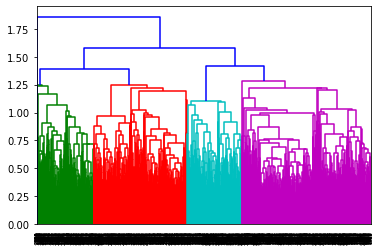

In [12]:
z = linkage(audio_features_norm, method = 'average', metric = 'euclidean')
plt.figure()
dn = dendrogram(z)
c, coph_dists = cophenet(z, pdist(audio_features_norm))
c

0.747302625630334

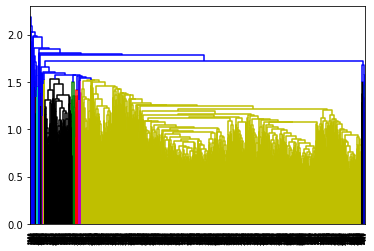

In [13]:
z = linkage(audio_analysis_norm, method = 'average', metric = 'euclidean')
plt.figure()
dn = dendrogram(z)
c, coph_dists = cophenet(z, pdist(audio_analysis_norm))
c

0.6075625000361728

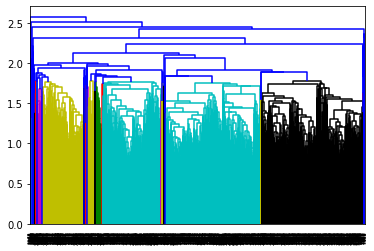

In [14]:
z = linkage(audio_tracks_norm, method = 'average', metric = 'euclidean')
plt.figure()
dn = dendrogram(z)
c, coph_dists = cophenet(z, pdist(audio_tracks_norm))
c

In [15]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='average')
cluster.fit_predict(audio_features_norm)

tmp = pd.DataFrame({'Generos': metadata.genre, 'audio_features': cluster.labels_})
ct = pd.crosstab(tmp['Generos'], tmp['audio_features'])
ct

audio_features,0,1,2,3,4
Generos,,,,,
ambient,187,60,148,0,65
classical,249,1,152,0,3
drum-and-bass,4,227,0,1,219
jazz,218,28,159,0,21
world-music,193,61,156,0,53


In [16]:
vanDongen(ct)

0.8013565891472868

In [17]:
adjusted_rand_score(metadata.genre, cluster.labels_)

0.12754503358419514

# Hiperparametrización

In [18]:
columns = ['Dataset', 'Method', 'Metric', 'Scaler', 'Cophenet', 'vanDongen', 'adjRand']
results = []

euclidean_methods = ['single', 'complete', 'average', 'ward']
methods = ['single', 'complete', 'average']

datasets = {
    "audio_features": audio_features,
    "audio_analysis": audio_analysis,
    "audio_tracks": audio_tracks
}

scalers = {
    "minMax": MinMaxScaler(feature_range=(0,1)),
    "standard": StandardScaler()
}

metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock',
           'correlation', 'cosine', 'dice', 'euclidean', 'hamming',
           'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski',
           'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener',
           'sokalsneath', 'sqeuclidean']

for dataset in datasets.keys():
    for metric in metrics:
        possible_methods = euclidean_methods if metric == 'euclidean' else methods
        for method in possible_methods:
            for scaler in scalers.keys():
                print(dataset + ', ' + metric + ', ' + method + ', ' + scaler)
                df = scalers[scaler].fit_transform(datasets[dataset])
                z = linkage(df, method = method, metric = metric)
                c, coph_dists = cophenet(z, pdist(df))                    
                cluster = AgglomerativeClustering(n_clusters = 5, affinity = metric, linkage = method)
                cluster.fit_predict(datasets[dataset])
                tmp = pd.DataFrame({'Generos': metadata.genre, 'clusters': cluster.labels_})
                ct = pd.crosstab(tmp['Generos'], tmp['clusters'])
                vd = vanDongen(ct)
                rand = adjusted_rand_score(metadata.genre, cluster.labels_)                    
                results.append([dataset, method, metric, scaler, c, vd, rand])
                    
df_results = pd.DataFrame(results, columns = columns)
df_results

audio_features, braycurtis, single, minMax
audio_features, braycurtis, single, standard
audio_features, braycurtis, complete, minMax
audio_features, braycurtis, complete, standard
audio_features, braycurtis, average, minMax
audio_features, braycurtis, average, standard
audio_features, canberra, single, minMax
audio_features, canberra, single, standard
audio_features, canberra, complete, minMax
audio_features, canberra, complete, standard
audio_features, canberra, average, minMax
audio_features, canberra, average, standard
audio_features, chebyshev, single, minMax
audio_features, chebyshev, single, standard
audio_features, chebyshev, complete, minMax
audio_features, chebyshev, complete, standard
audio_features, chebyshev, average, minMax
audio_features, chebyshev, average, standard
audio_features, cityblock, single, minMax
audio_features, cityblock, single, standard
audio_features, cityblock, complete, minMax
audio_features, cityblock, complete, standard
audio_features, cityblock, avera

/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_features, dice, complete, minMax
audio_features, dice, complete, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_features, dice, average, minMax
audio_features, dice, average, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_features, euclidean, single, minMax
audio_features, euclidean, single, standard
audio_features, euclidean, complete, minMax
audio_features, euclidean, complete, standard
audio_features, euclidean, average, minMax
audio_features, euclidean, average, standard
audio_features, euclidean, ward, minMax
audio_features, euclidean, ward, standard
audio_features, hamming, single, minMax
audio_features, hamming, single, standard
audio_features, hamming, complete, minMax
audio_features, hamming, complete, standard
audio_features, hamming, average, minMax
audio_features, hamming, average, standard
audio_features, jaccard, single, minMax
audio_features, jaccard, single, standard
audio_features, jaccard, complete, minMax
audio_features, jaccard, complete, standard
audio_features, jaccard, average, minMax
audio_features, jaccard, average, standard
audio_features, kulsinski, single, minMax
audio_features, kulsinski, single, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_features, kulsinski, complete, minMax
audio_features, kulsinski, complete, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_features, kulsinski, average, minMax
audio_features, kulsinski, average, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_features, mahalanobis, single, minMax
audio_features, mahalanobis, single, standard
audio_features, mahalanobis, complete, minMax
audio_features, mahalanobis, complete, standard
audio_features, mahalanobis, average, minMax
audio_features, mahalanobis, average, standard
audio_features, matching, single, minMax
audio_features, matching, single, standard
audio_features, matching, complete, minMax
audio_features, matching, complete, standard
audio_features, matching, average, minMax
audio_features, matching, average, standard
audio_features, minkowski, single, minMax
audio_features, minkowski, single, standard
audio_features, minkowski, complete, minMax
audio_features, minkowski, complete, standard
audio_features, minkowski, average, minMax
audio_features, minkowski, average, standard
audio_features, rogerstanimoto, single, minMax
audio_features, rogerstanimoto, single, standard
audio_features, rogerstanimoto, complete, minMax


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_features, rogerstanimoto, complete, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_features, rogerstanimoto, average, minMax
audio_features, rogerstanimoto, average, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_features, russellrao, single, minMax
audio_features, russellrao, single, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_features, russellrao, complete, minMax
audio_features, russellrao, complete, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_features, russellrao, average, minMax
audio_features, russellrao, average, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_features, seuclidean, single, minMax
audio_features, seuclidean, single, standard
audio_features, seuclidean, complete, minMax
audio_features, seuclidean, complete, standard
audio_features, seuclidean, average, minMax
audio_features, seuclidean, average, standard
audio_features, sokalmichener, single, minMax
audio_features, sokalmichener, single, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_features, sokalmichener, complete, minMax
audio_features, sokalmichener, complete, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_features, sokalmichener, average, minMax
audio_features, sokalmichener, average, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_features, sokalsneath, single, minMax
audio_features, sokalsneath, single, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_features, sokalsneath, complete, minMax
audio_features, sokalsneath, complete, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_features, sokalsneath, average, minMax
audio_features, sokalsneath, average, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_features, sqeuclidean, single, minMax
audio_features, sqeuclidean, single, standard
audio_features, sqeuclidean, complete, minMax
audio_features, sqeuclidean, complete, standard
audio_features, sqeuclidean, average, minMax
audio_features, sqeuclidean, average, standard
audio_analysis, braycurtis, single, minMax
audio_analysis, braycurtis, single, standard
audio_analysis, braycurtis, complete, minMax
audio_analysis, braycurtis, complete, standard
audio_analysis, braycurtis, average, minMax
audio_analysis, braycurtis, average, standard
audio_analysis, canberra, single, minMax
audio_analysis, canberra, single, standard
audio_analysis, canberra, complete, minMax
audio_analysis, canberra, complete, standard
audio_analysis, canberra, average, minMax
audio_analysis, canberra, average, standard
audio_analysis, chebyshev, single, minMax
audio_analysis, chebyshev, single, standard
audio_analysis, chebyshev, complete, minMax
audio_analysis, chebyshev, complete, standard
audio_analysis, cheb

/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_analysis, dice, complete, minMax
audio_analysis, dice, complete, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_analysis, dice, average, minMax
audio_analysis, dice, average, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_analysis, euclidean, single, minMax
audio_analysis, euclidean, single, standard
audio_analysis, euclidean, complete, minMax
audio_analysis, euclidean, complete, standard
audio_analysis, euclidean, average, minMax
audio_analysis, euclidean, average, standard
audio_analysis, euclidean, ward, minMax
audio_analysis, euclidean, ward, standard
audio_analysis, hamming, single, minMax
audio_analysis, hamming, single, standard
audio_analysis, hamming, complete, minMax
audio_analysis, hamming, complete, standard
audio_analysis, hamming, average, minMax
audio_analysis, hamming, average, standard
audio_analysis, jaccard, single, minMax
audio_analysis, jaccard, single, standard
audio_analysis, jaccard, complete, minMax
audio_analysis, jaccard, complete, standard
audio_analysis, jaccard, average, minMax
audio_analysis, jaccard, average, standard
audio_analysis, kulsinski, single, minMax
audio_analysis, kulsinski, single, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_analysis, kulsinski, complete, minMax
audio_analysis, kulsinski, complete, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_analysis, kulsinski, average, minMax
audio_analysis, kulsinski, average, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_analysis, mahalanobis, single, minMax
audio_analysis, mahalanobis, single, standard
audio_analysis, mahalanobis, complete, minMax
audio_analysis, mahalanobis, complete, standard
audio_analysis, mahalanobis, average, minMax
audio_analysis, mahalanobis, average, standard
audio_analysis, matching, single, minMax
audio_analysis, matching, single, standard
audio_analysis, matching, complete, minMax
audio_analysis, matching, complete, standard
audio_analysis, matching, average, minMax
audio_analysis, matching, average, standard
audio_analysis, minkowski, single, minMax
audio_analysis, minkowski, single, standard
audio_analysis, minkowski, complete, minMax
audio_analysis, minkowski, complete, standard
audio_analysis, minkowski, average, minMax
audio_analysis, minkowski, average, standard
audio_analysis, rogerstanimoto, single, minMax
audio_analysis, rogerstanimoto, single, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_analysis, rogerstanimoto, complete, minMax
audio_analysis, rogerstanimoto, complete, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_analysis, rogerstanimoto, average, minMax
audio_analysis, rogerstanimoto, average, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_analysis, russellrao, single, minMax
audio_analysis, russellrao, single, standard
audio_analysis, russellrao, complete, minMax


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_analysis, russellrao, complete, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_analysis, russellrao, average, minMax
audio_analysis, russellrao, average, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_analysis, seuclidean, single, minMax
audio_analysis, seuclidean, single, standard
audio_analysis, seuclidean, complete, minMax
audio_analysis, seuclidean, complete, standard
audio_analysis, seuclidean, average, minMax
audio_analysis, seuclidean, average, standard
audio_analysis, sokalmichener, single, minMax
audio_analysis, sokalmichener, single, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_analysis, sokalmichener, complete, minMax
audio_analysis, sokalmichener, complete, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_analysis, sokalmichener, average, minMax
audio_analysis, sokalmichener, average, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_analysis, sokalsneath, single, minMax
audio_analysis, sokalsneath, single, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_analysis, sokalsneath, complete, minMax
audio_analysis, sokalsneath, complete, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_analysis, sokalsneath, average, minMax
audio_analysis, sokalsneath, average, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_analysis, sqeuclidean, single, minMax
audio_analysis, sqeuclidean, single, standard
audio_analysis, sqeuclidean, complete, minMax
audio_analysis, sqeuclidean, complete, standard
audio_analysis, sqeuclidean, average, minMax
audio_analysis, sqeuclidean, average, standard
audio_tracks, braycurtis, single, minMax
audio_tracks, braycurtis, single, standard
audio_tracks, braycurtis, complete, minMax
audio_tracks, braycurtis, complete, standard
audio_tracks, braycurtis, average, minMax
audio_tracks, braycurtis, average, standard
audio_tracks, canberra, single, minMax
audio_tracks, canberra, single, standard
audio_tracks, canberra, complete, minMax
audio_tracks, canberra, complete, standard
audio_tracks, canberra, average, minMax
audio_tracks, canberra, average, standard
audio_tracks, chebyshev, single, minMax
audio_tracks, chebyshev, single, standard
audio_tracks, chebyshev, complete, minMax
audio_tracks, chebyshev, complete, standard
audio_tracks, chebyshev, average, minMax
audio_track

/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_tracks, dice, complete, minMax
audio_tracks, dice, complete, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_tracks, dice, average, minMax
audio_tracks, dice, average, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_tracks, euclidean, single, minMax
audio_tracks, euclidean, single, standard
audio_tracks, euclidean, complete, minMax
audio_tracks, euclidean, complete, standard
audio_tracks, euclidean, average, minMax
audio_tracks, euclidean, average, standard
audio_tracks, euclidean, ward, minMax
audio_tracks, euclidean, ward, standard
audio_tracks, hamming, single, minMax
audio_tracks, hamming, single, standard
audio_tracks, hamming, complete, minMax
audio_tracks, hamming, complete, standard
audio_tracks, hamming, average, minMax
audio_tracks, hamming, average, standard
audio_tracks, jaccard, single, minMax
audio_tracks, jaccard, single, standard
audio_tracks, jaccard, complete, minMax
audio_tracks, jaccard, complete, standard
audio_tracks, jaccard, average, minMax
audio_tracks, jaccard, average, standard
audio_tracks, kulsinski, single, minMax
audio_tracks, kulsinski, single, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_tracks, kulsinski, complete, minMax
audio_tracks, kulsinski, complete, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_tracks, kulsinski, average, minMax
audio_tracks, kulsinski, average, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_tracks, mahalanobis, single, minMax
audio_tracks, mahalanobis, single, standard
audio_tracks, mahalanobis, complete, minMax
audio_tracks, mahalanobis, complete, standard
audio_tracks, mahalanobis, average, minMax
audio_tracks, mahalanobis, average, standard
audio_tracks, matching, single, minMax
audio_tracks, matching, single, standard
audio_tracks, matching, complete, minMax
audio_tracks, matching, complete, standard
audio_tracks, matching, average, minMax
audio_tracks, matching, average, standard
audio_tracks, minkowski, single, minMax
audio_tracks, minkowski, single, standard
audio_tracks, minkowski, complete, minMax
audio_tracks, minkowski, complete, standard
audio_tracks, minkowski, average, minMax
audio_tracks, minkowski, average, standard
audio_tracks, rogerstanimoto, single, minMax
audio_tracks, rogerstanimoto, single, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_tracks, rogerstanimoto, complete, minMax
audio_tracks, rogerstanimoto, complete, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_tracks, rogerstanimoto, average, minMax
audio_tracks, rogerstanimoto, average, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_tracks, russellrao, single, minMax
audio_tracks, russellrao, single, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_tracks, russellrao, complete, minMax
audio_tracks, russellrao, complete, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_tracks, russellrao, average, minMax
audio_tracks, russellrao, average, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_tracks, seuclidean, single, minMax
audio_tracks, seuclidean, single, standard
audio_tracks, seuclidean, complete, minMax
audio_tracks, seuclidean, complete, standard
audio_tracks, seuclidean, average, minMax
audio_tracks, seuclidean, average, standard
audio_tracks, sokalmichener, single, minMax
audio_tracks, sokalmichener, single, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_tracks, sokalmichener, complete, minMax
audio_tracks, sokalmichener, complete, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_tracks, sokalmichener, average, minMax
audio_tracks, sokalmichener, average, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_tracks, sokalsneath, single, minMax
audio_tracks, sokalsneath, single, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_tracks, sokalsneath, complete, minMax
audio_tracks, sokalsneath, complete, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_tracks, sokalsneath, average, minMax
audio_tracks, sokalsneath, average, standard


/home/frasco/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


audio_tracks, sqeuclidean, single, minMax
audio_tracks, sqeuclidean, single, standard
audio_tracks, sqeuclidean, complete, minMax
audio_tracks, sqeuclidean, complete, standard
audio_tracks, sqeuclidean, average, minMax
audio_tracks, sqeuclidean, average, standard


,Dataset,Method,Metric,Scaler,Cophenet,vanDongen,adjRand
0,audio_features,single,braycurtis,minMax,0.317106,0.997709,0.000049
1,audio_features,single,braycurtis,standard,0.102797,0.997709,0.000049
2,audio_features,complete,braycurtis,minMax,0.607225,0.935654,0.019142
3,audio_features,complete,braycurtis,standard,0.346391,0.935654,0.019142
4,audio_features,average,braycurtis,minMax,0.670574,0.954740,0.012020
5,audio_features,average,braycurtis,standard,0.449241,0.954740,0.012020
6,audio_features,single,canberra,minMax,0.186327,0.997709,0.000059
7,audio_features,single,canberra,standard,0.031198,0.997709,0.000059
8,audio_features,complete,canberra,minMax,0.489960,0.750460,0.155931
9,audio_features,complete,canberra,standard,0.301188,0.750460,0.155931


In [19]:
df_results.to_csv('hierarchical.csv', index = False)